In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from datetime import datetime
from helper import *

In [83]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
import altair as alt
from matplotlib.pyplot import style
import plotly.express as px
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import re
from tabulate import tabulate
import nltk
from nltk.probability import FreqDist

In [ ]:
#loading lisitngs data
listings_detail_df = pd.read_csv('/content/gdrive/MyDrive/Airbnb/listings.csv', low_memory=False,
                                 parse_dates=['host_since',
                                              'last_scraped', 'calendar_last_scraped',
                                              'first_review', 'last_review'])

gdf = gpd.read_file('/content/gdrive/MyDrive/Airbnb/neighbourhoods.geojson')

# Drop duplicates
listings_detail_df = listings_detail_df.drop_duplicates()

listings_detail_df.loc[:, listings_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

# Q 1) What are the mean prices for each neighbourhood? Which neighbourhood is the most expesnive and least expensive in terms of average price? Also, how many listings are there in each neighbourhood?


# A) Westminster is the most expensive with an average price ~321 whereas Sutton is the least expensive with an average price of ~90.

# Surprisingly, westminster has the highest no of listings too whereas sutton has the least number of properties listed on airbnb.

In [46]:
# Reformatting % and $ sign from host_acceptance_rate and price column respectively
listings_detail_df["host_acceptance_rate"] = listings_detail_df["host_acceptance_rate"].str.replace("%","")
listings_detail_df["price"] = listings_detail_df["price"].str.replace("$","")
listings_detail_df["price"] = listings_detail_df["price"].str.replace(",","")

#Changing values from strings to float
listings_detail_df["host_acceptance_rate"] = listings_detail_df["host_acceptance_rate"].astype(float)
listings_detail_df["price"] = listings_detail_df["price"].astype(float)



<ipython-input-46-84e0d5242d37>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



+----+------------------------+-------+--------------------+
|    |     Neighbourhood      | Count |        Mean        |
+----+------------------------+-------+--------------------+
| 0  |  Barking and Dagenham  |  564  | 245.8404255319149  |
| 1  |         Barnet         | 2249  | 160.5233437083148  |
| 2  |         Bexley         |  495  | 95.04646464646464  |
| 3  |         Brent          | 2740  | 179.07919708029198 |
| 4  |        Bromley         |  772  | 105.97279792746114 |
| 5  |         Camden         | 5757  | 203.2881709223554  |
| 6  |     City of London     |  536  | 243.72201492537314 |
| 7  |        Croydon         | 1506  | 91.06573705179282  |
| 8  |         Ealing         | 2169  | 125.22083909635776 |
| 9  |        Enfield         |  820  | 107.15975609756097 |
| 10 |       Greenwich        | 1927  | 121.99636741048262 |
| 11 |        Hackney         | 6182  | 132.93222258168876 |
| 12 | Hammersmith and Fulham | 3795  | 177.2308300395257  |
| 13 |        Haringey  

<ipython-input-65-f301b60a9bd2>:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



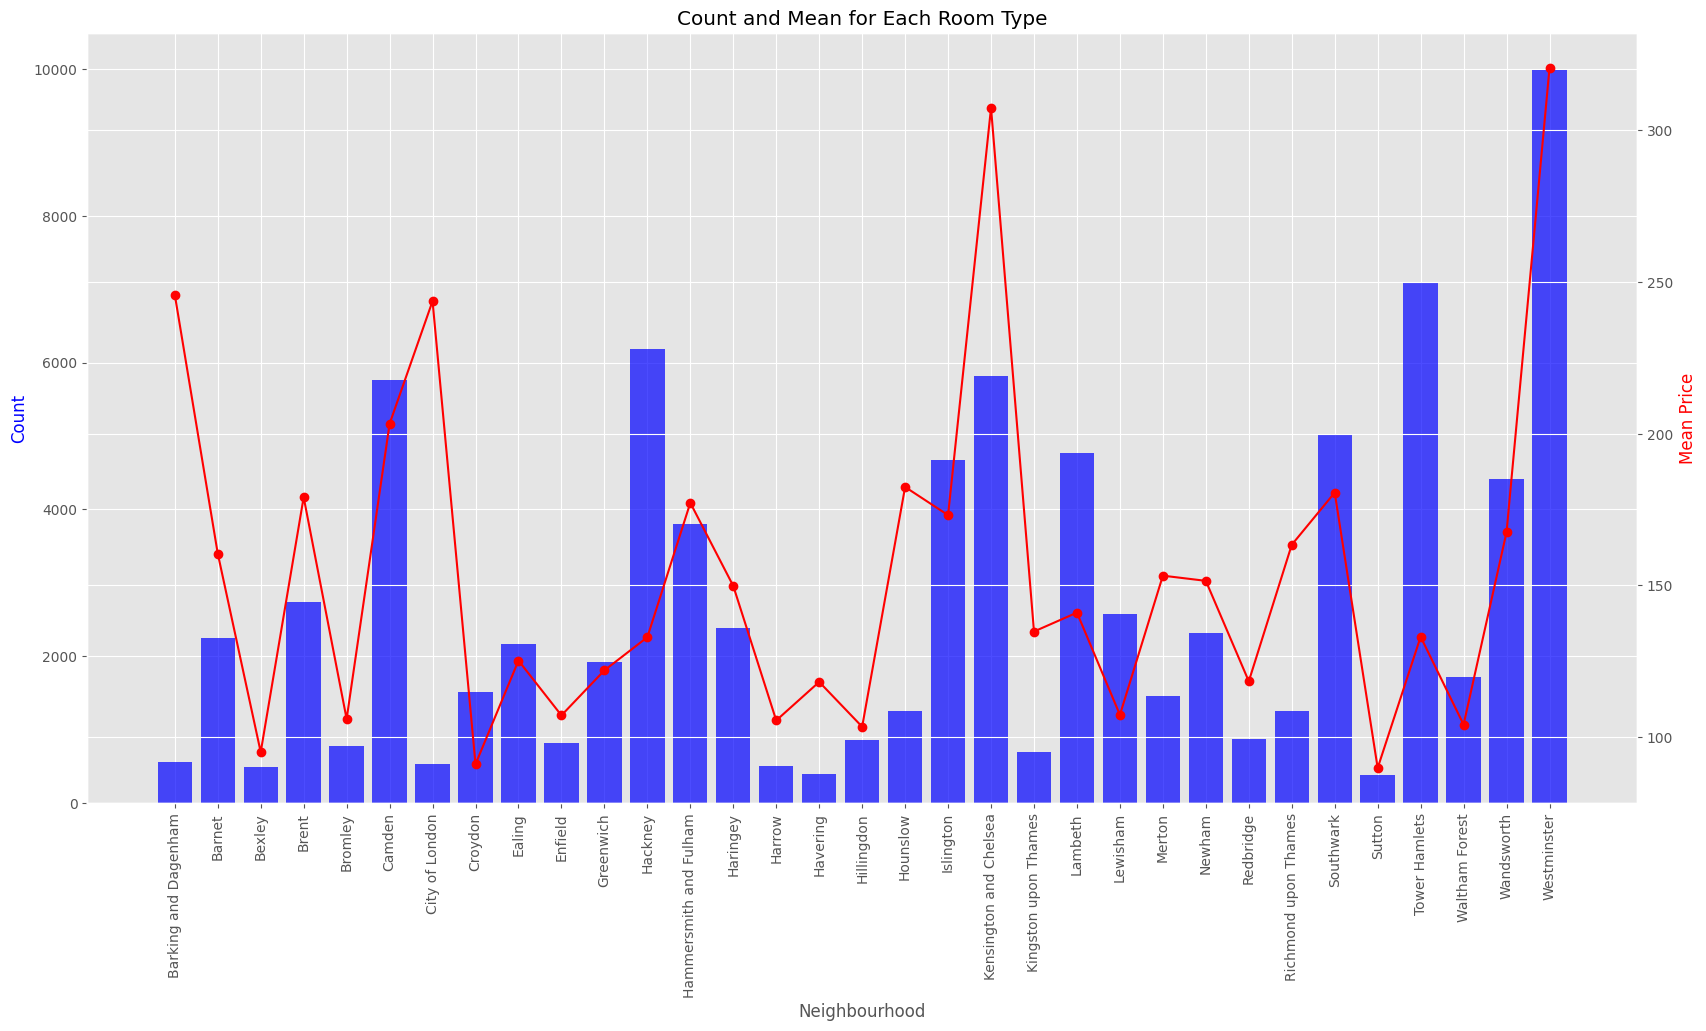

In [65]:
#grouping by neighbourhood column

average_prices_by_neighbourhood = listings_detail_df.groupby('neighbourhood_cleansed').agg({'price': ['count', 'mean']}).reset_index()
average_prices_by_neighbourhood.columns = ['Neighbourhood', 'Count', 'Mean']
# Print or display the result

print(tabulate(average_prices_by_neighbourhood, headers='keys', tablefmt='pretty'))

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 10))

# Bar plot for count
ax1.bar(average_prices_by_neighbourhood['Neighbourhood'], average_prices_by_neighbourhood['Count'], color='blue', alpha=0.7, label='Count')

# Creating a secondary y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(average_prices_by_neighbourhood['Neighbourhood'], average_prices_by_neighbourhood['Mean'], marker='o', color='red', label='Mean')

# Adding labels and title
ax1.set_xticklabels(average_prices_by_neighbourhood['Neighbourhood'], rotation='vertical')

ax1.set_xlabel('Neighbourhood')
ax1.set_ylabel('Count', color='blue')
ax2.set_ylabel('Mean Price', color='red')
ax1.set_title('Count and Mean for Each Room Type')

# Show the plot
plt.show()


## Q 2) What are the different room types and their respective counts? What are their average prices?


# A)Entire home/apt has the highest no of listings whereas hotel room has the highest average price (hotel rooms make up less than 1% of total listings)

+---+-----------------+-------+--------------------+
|   |    Room Type    | Count |        Mean        |
+---+-----------------+-------+--------------------+
| 0 | Entire home/apt | 54575 | 230.16853870819972 |
| 1 |   Hotel room    |  219  | 256.09589041095893 |
| 2 |  Private room   | 32711 | 100.23120662773991 |
| 3 |   Shared room   |  441  | 119.71655328798185 |
+---+-----------------+-------+--------------------+


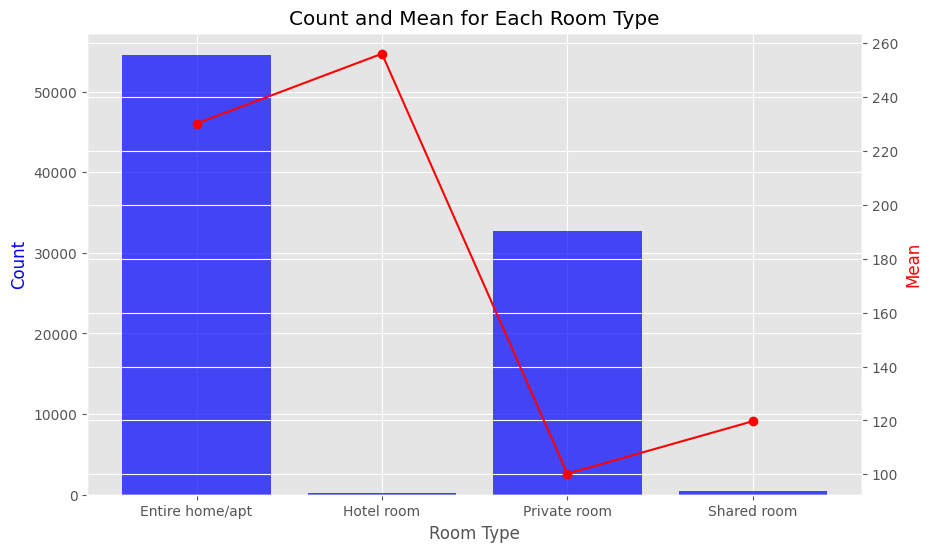

In [75]:
room_types_count_prices = listings_detail_df.groupby('room_type').agg({'price': ['count', 'mean']}).reset_index()
room_types_count_prices.columns = ['Room Type', 'Count', 'Mean']

print(tabulate(room_types_count_prices, headers='keys', tablefmt='pretty'))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for count
ax1.bar(room_types_count_prices['Room Type'], room_types_count_prices['Count'], color='blue', alpha=0.7, label='Count')

# Creating a secondary y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(room_types_count_prices['Room Type'], room_types_count_prices['Mean'], marker='o', color='red', label='Mean')

# Adding labels and title
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Count', color='blue')
ax2.set_ylabel('Mean', color='red')
ax1.set_title('Count and Mean for Each Room Type')

# Show the plot
plt.show()

#Q 3)Do the listings with higher review scores charge more? Also is the result statistically significant?


# A) From the analysis, there does not seem to be any correlation with review scores and prices.

# The analysis was done by first calcualting the mean score from all the review score columns. Then for the new mean score column, the average was determined.
# A new column was defined based on the average score with 2 categories, above average and below average.

#It was also checked that the test is statistically signifcant and the test holds.

In [ ]:
#choosing a subset from the main table
listings_4=listings_detail_df[['price','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']]

#removing Nulls from the data
listings_4.dropna(inplace=True)
listings_4.reset_index(drop=True, inplace=True)

#computing average mean from all the review columns
review_columns = listings_4.filter(like='review')
mean_review = review_columns.mean(axis=1)

#finding average 'mean score'
listings_4['mean_review'] = mean_review
mean_review_score=listings_4['mean_review'].mean()

#categorizing into two main lodging categories based upon review scores
listings_4['Lodging Quality'] = np.where(listings_4['mean_review']<mean_review_score,'Below Average','Above Average')

+---+-----------------+--------------------+
|   | Lodging Quality |       price        |
+---+-----------------+--------------------+
| 0 |  Above Average  | 160.10915034173772 |
| 1 |  Below Average  | 167.39847088992306 |
+---+-----------------+--------------------+


With 95% confidence, the analysis holds. People with higher reviews dont charge more




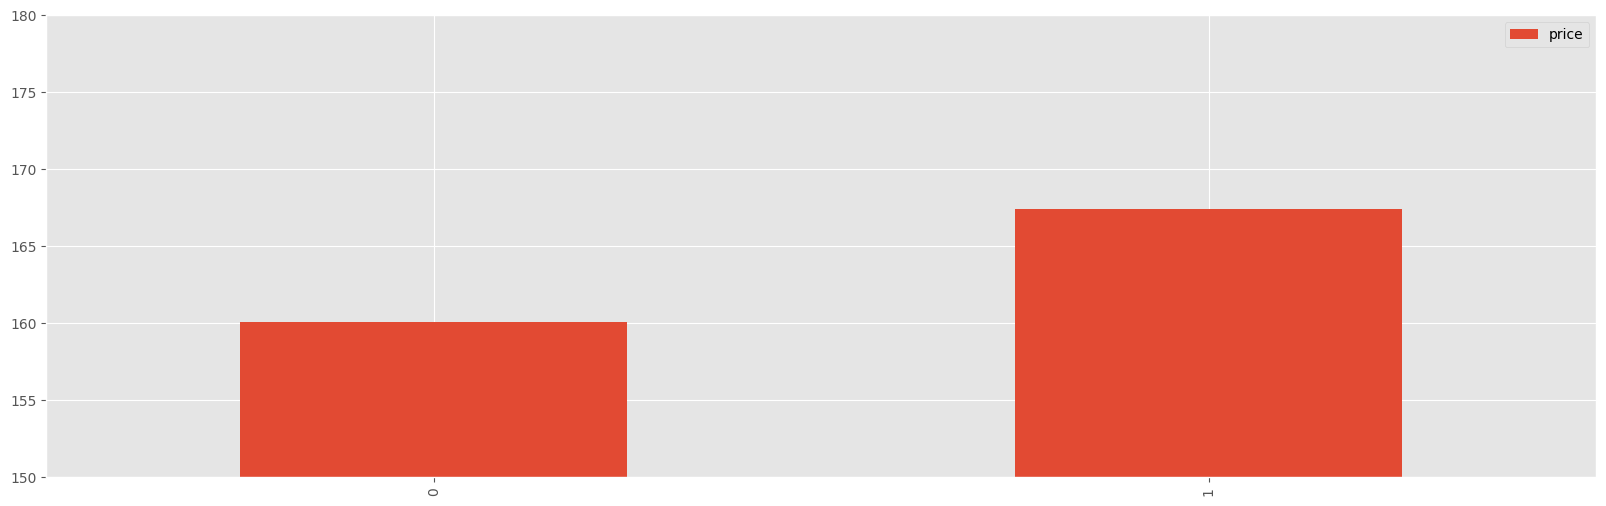

In [79]:
#grouping by newly created column lodging quality to check the average prices
result_4=listings_4.groupby('Lodging Quality')['price'].mean().reset_index()

print(tabulate(result_4, headers='keys', tablefmt='pretty'))
result_4.plot(kind='bar', ylim = (150,180))

#checking whether its statistically significant

# Separate the data into two groups
above_average = listings_4[listings_4['Lodging Quality'] == 'Above Average']['price']
below_average = listings_4[listings_4['Lodging Quality'] == 'Below Average']['price']


# Perform an independent t-test
t_statistic, p_value = ttest_ind(above_average, below_average, alternative='less')

# Check if the p-value is less than 0.05 (assuming a 95% confidence level)
confidence_level = 0.05
result = p_value < confidence_level

print("\n")
if result:
    print('\033[1mWith 95% confidence, the analysis holds. People with higher reviews dont charge more\033[0m')
else:
    print("There is not enough evidence to conclude that smokers weigh less than non-smokers.")


print("\n")

# Q 4) Which neighbourhood is generating maximum and minimum revenues in terms of room types?

# A) Answers given in cells
# - Westminster and Sutton have the highest and lowest revenue per night for both private rooms and entire room/apt.
# - Camden has the maximum revenue for shared room whereas Havering has the lowest revenue for shared rooms


In [16]:
df_n_roomtype = listings_detail_df.groupby(['neighbourhood_cleansed','room_type']).agg({'price':'sum'})
df_n_roomtype = pd.pivot_table(df_n_roomtype, values='price', index=['neighbourhood_cleansed'], columns=['room_type'])

In [17]:
#Maximum revenue in Private Rooms
a=df_n_roomtype.sort_values('Private room', ascending = False).head(1)
styled_pivot_a = a.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMaximum revenue in Private Room\033[0m')
styled_pivot_a



Maximum revenue in Private Room


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Westminster,2762568.000000,19705.000000,408766.000000,12310.000000


In [18]:
#Minimum revenue in Private Rooms
b=df_n_roomtype.sort_values('Private room', ascending = True).head(1)
styled_pivot_b = b.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMinimum revenue in Private Rooms\033[0m')
styled_pivot_b

Minimum revenue in Private Rooms


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Sutton,23042.000000,nan,10880.000000,300.000000


In [19]:
#Maximum revenue in Entire home/apt
c=df_n_roomtype.sort_values('Entire home/apt', ascending = False).head(1)
styled_pivot_c = c.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMaximum revenue in Entire home/apt\033[0m')
styled_pivot_c

Maximum revenue in Entire home/apt


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Westminster,2762568.000000,19705.000000,408766.000000,12310.000000


In [20]:
#Minimum revenue in Entire home/apt
d=df_n_roomtype.sort_values('Entire home/apt', ascending = True).head(1)
styled_pivot_d = d.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMinimum revenue in Entire home/apt\033[0m')
styled_pivot_d

Minimum revenue in Entire home/apt


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Sutton,23042.000000,nan,10880.000000,300.000000


In [21]:
#Maximum revenue in Shared room
e=df_n_roomtype.sort_values('Shared room', ascending = False).head(1)
styled_pivot_e = e.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMaximum revenue in Shared rooms\033[0m')
styled_pivot_e

Maximum revenue in Shared rooms


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Camden,970769.000000,1983.000000,183983.000000,13595.000000


In [22]:
#Minimum revenue in Shared room
f=df_n_roomtype.sort_values('Shared room', ascending = True).head(1)
styled_pivot_f = f.style.background_gradient(cmap='YlGnBu').highlight_max(axis=0)
print('\033[1mMinimum revenue in Shared rooms\033[0m')
styled_pivot_f

Minimum revenue in Shared rooms


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Havering,35578.000000,nan,10939.000000,50.000000


# Q 5) How many unique owners are there by region?

# A) The no of unique owners for each neighborhood is diplayed in the the graph

Text(0, 0.5, 'Host Count')

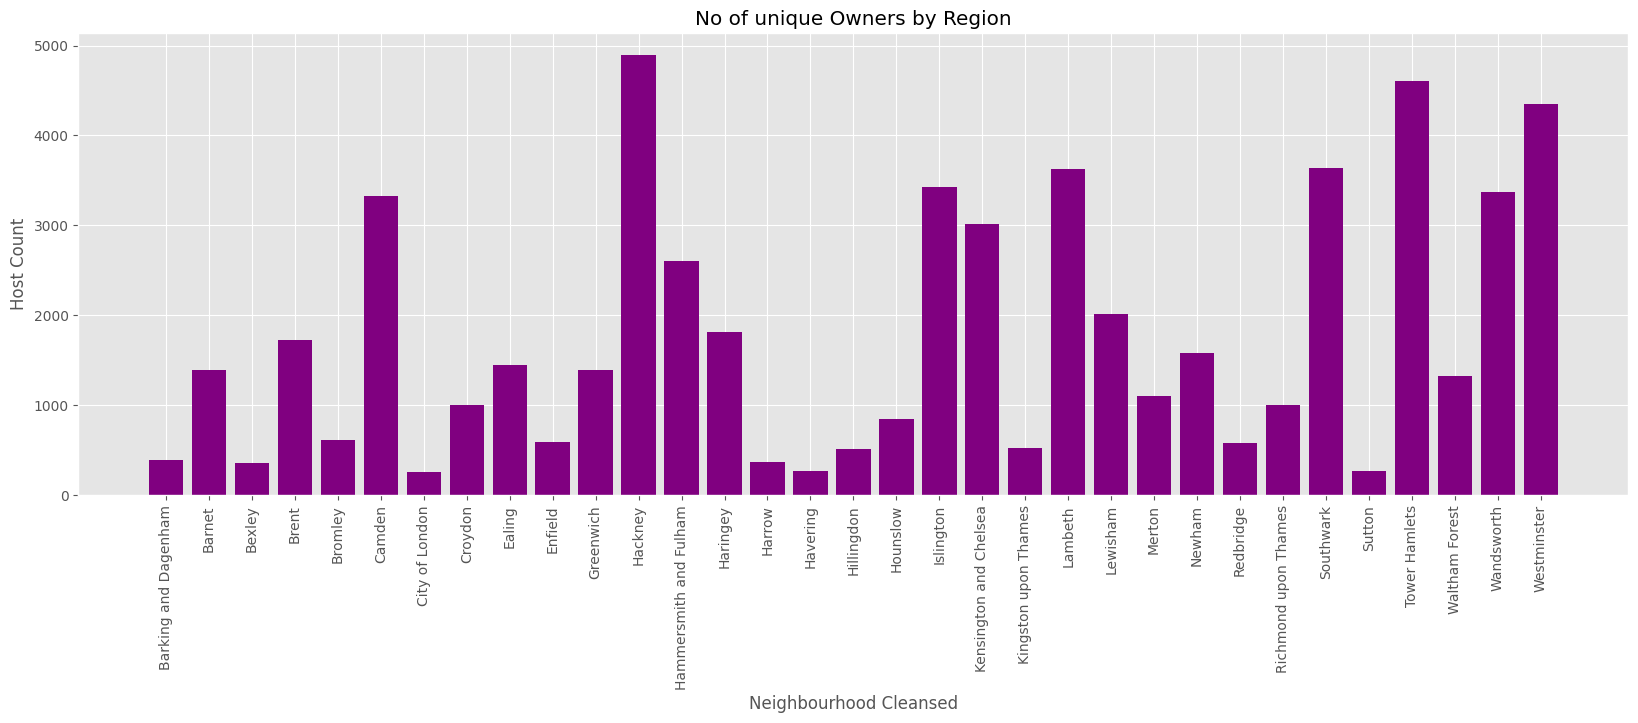

In [125]:
# Select columns and perform mathematical operation
owners_by_region = listings_detail_df.loc[:, ['host_id', 'neighbourhood_cleansed']].groupby('neighbourhood_cleansed').nunique()

owners_by_region.reset_index(inplace=True)

plt.bar(owners_by_region['neighbourhood_cleansed'], owners_by_region['host_id'], color='purple')
# Adding title and labels
plt.xticks(rotation='vertical')
plt.title('No of unique Owners by Region')
plt.xlabel('Neighbourhood Cleansed')
plt.ylabel('Host Count')

# Q 6) What are the most frequently listed amenities and their respective count?

# A) The top 3 amenities are:

- wifi
- smoke alarm
- kitches

# Rest are shown in graph

In [ ]:
main_df=listings_detail_df[['amenities','price']]
main_df['amenities']=main_df['amenities'].str.replace('{}','').str.replace('{ }','')

main_df['amenities']=main_df['amenities'].str.replace(
    '$','').str.replace('{','').str.replace('}','').str.replace(
    '"','').str.replace(' toilet','toilet').str.replace('Cable TV','TV')

main_df.replace('', np.nan, inplace=True)


def get_amenities(df,message1,message2):
    all_amenities=df['amenities'].tolist()
    #all_amenities=','.join(all_amenities).split(',')
    all_amenities=','.join(map(str, all_amenities)).split(',')
    #all_amenities=list(all_amenities)
    #x='\'\''
    #if x in all_amenities: print('Yes')
    unique_amenities=set(all_amenities)
    unique_amenities=list(unique_amenities)
    print()
    print(message1.format(len(unique_amenities)),'\n')
    print(message2.format(sorted(unique_amenities)))

    return (all_amenities,unique_amenities)

def amenities_frequency_plot(amenities,title,plot):

    fdist = FreqDist(amenities)
    d = pd.DataFrame({'Amenity': list(fdist.keys()),'Count': list(fdist.values())})
    #print(d.shape)
    d2=d.copy()
    d2 = d2.nlargest(columns="Count", n = 25)

    if plot==True:
        plt.style.use('ggplot')
        plt.rcParams['figure.figsize']=(20,6)
        plt.style.use(style='ggplot')
        d2.plot(x='Amenity',y='Count',kind='bar',color='red')
        plt.ylabel('Frequency',fontsize=25,color='blue')
        #plt.xlabel('Amenity',fontsize=25,color='blue')
        plt.title(title,fontsize=25,color='blue')
        #plt.xlabel('Amenity',fontsize=12)
        plt.tick_params(labelsize=20)
        plt.xticks(rotation='vertical')
        plt.show()

    return d

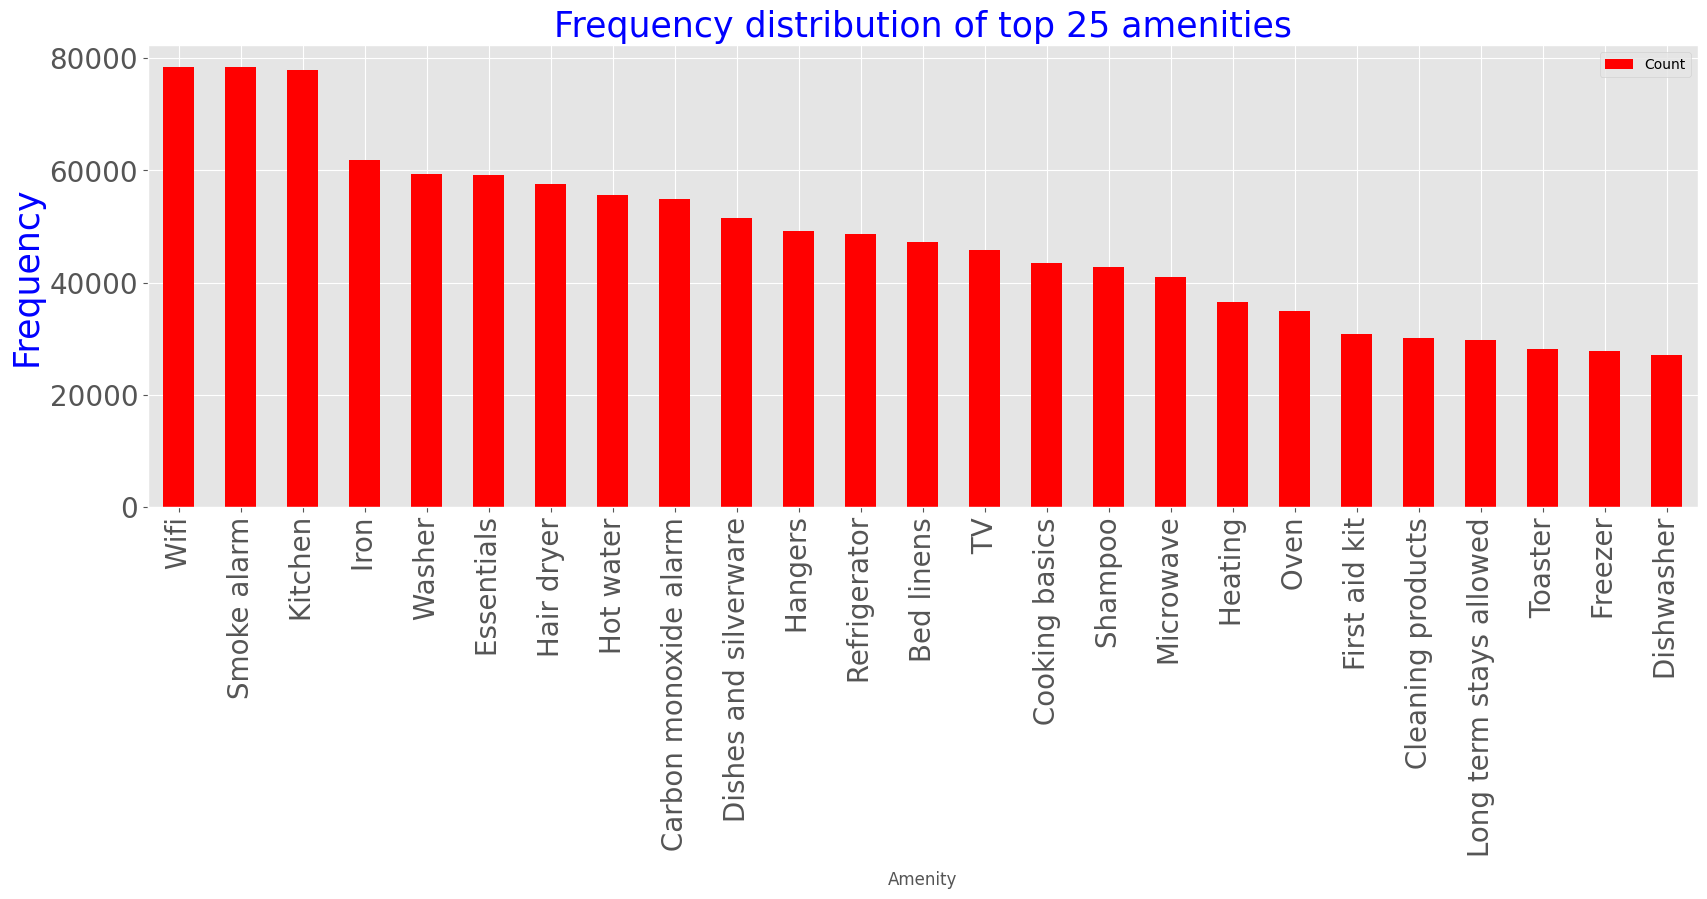

In [44]:
df = main_df
message1='Number of unique amenities is {}'
message2='List of amenities={}'
all_amenities_listings,unique_amenities_listings = get_amenities(df,message1,message2)

amenities=all_amenities_listings
title='Frequency distribution of top 25 amenities'
amenities_freq_dist_train=amenities_frequency_plot(amenities,title,True)

In [87]:
print('The top 10 amenities and their respective counts are:')
amenities_freq_dist_train.nlargest(columns="Count", n = 10)

The top 10 amenities are:


,Amenity,Count
2,Wifi,78388
3,Smoke alarm,78368
5,Kitchen,77956
23,Iron,61909
6,Washer,59335
41,Essentials,59240
40,Hair dryer,57578
22,Hot water,55577
45,Carbon monoxide alarm,54927
50,Dishes and silverware,51436


# Q 7) What are the top Price determining features?

# A) The features were determined using feature importances of a ML model. All the necessary steps were performed to train the model. The data was first pre-processed by filling NULLs with mode values. Then for features with only two vategories were encoded with boolean values, 1 and 0. The categorical features were one-hot encoded and then a random forest model was trained.

The most immportant features affecting the price are:
- reviews per month
- minimum nights
- host acceptance rate

In [ ]:
#selecting necessary columns
data = listings_detail_df[['price','bedrooms','accommodates','beds', 'neighbourhood_cleansed','room_type','minimum_nights','reviews_per_month','host_acceptance_rate','instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']]

#encoding features with two categories with 1 and 0
binary_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
binary_map = {'f': 0, 't': 1}
data[binary_cols] = data[binary_cols].apply(lambda x: x.map(binary_map)).astype(float)

#defining impute function

def impute_mode(df, variable):
    '''
    Usage: replace NaN with the mode in specific column
    Input arguments:
    df  -- a dataframe object
    variable -- a column where you want to apply imputation

    Return: None
    '''
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]

    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)

#imputing null values with mode
impute_cols = data.columns[data.isnull().any()]
for col in impute_cols:
    impute_mode(data, col)


#one-hot encoding categorical features
cat_features = ['neighbourhood_cleansed',  'room_type']
data = pd.get_dummies(data = data, columns = cat_features)

#normalizing features
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)

Root Mean Squared Error (RMSE): 561.7437819435443
Feature Importance:
                                          Feature  Importance
4                               reviews_per_month    0.278527
3                                  minimum_nights    0.160148
5                            host_acceptance_rate    0.123082
0                                        bedrooms    0.075273
1                                    accommodates    0.063094
6                                instant_bookable    0.053722
2                                            beds    0.052189
28               neighbourhood_cleansed_Islington    0.039951
9                          host_identity_verified    0.035146
42             neighbourhood_cleansed_Westminster    0.020946
43                      room_type_Entire home/apt    0.017230
29  neighbourhood_cleansed_Kensington and Chelsea    0.012756
45                         room_type_Private room    0.009953
7                               host_is_superhost    0.006249


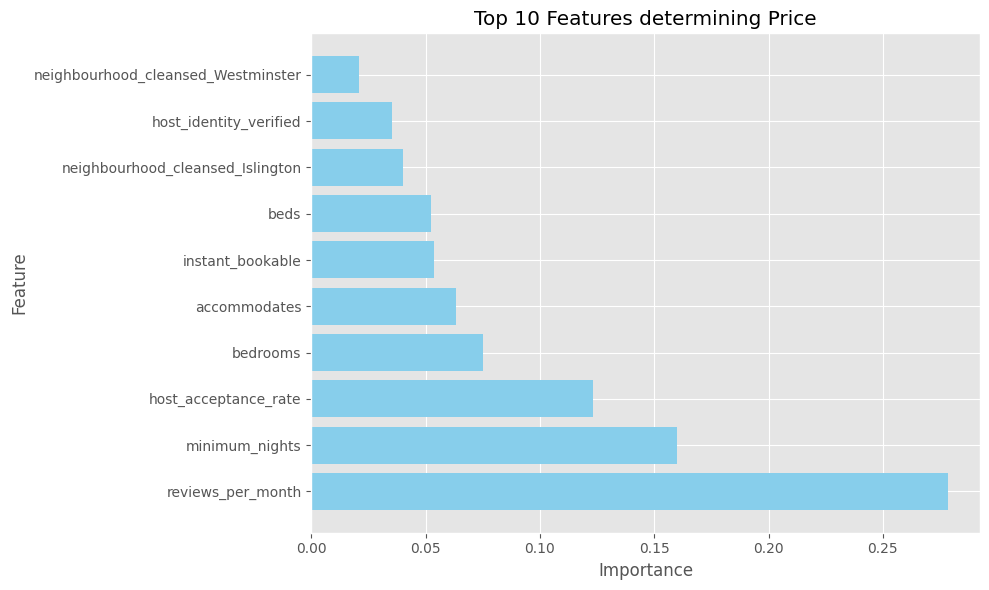

In [100]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np



features = data.drop('price', axis=1)
target = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Display feature importance
feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print('Feature Importance:')
print(feature_importance.head(15))


top_10_features = feature_importance.head(10)

# Plot the top 10 feature importance with horizontal bars
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features determining Price')
plt.tight_layout()
plt.show()

# Q 8) How does the review scores vary acorss different neighbourhoods?

# A) Overall the neighbourhoods with much better review scores are
# richmond and kingston. The guests feel they got a better value for money in these two places. Both these neighbourhoods have been highlly ranked for location as well.

# Hillingdon was rated the lowest overall.

# Camden, Westminster & Kensington and Chelsea were rated lowest in terms of value probably because they are in central London. These neighbourhoods, however, have a higher rating for location.

## Cleanliness and Value have a low average score overall whereas check-in and communication seem to have the higher value.


In [97]:
#selecting sutiable columns
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols = ['host_since', 'host_response_time',
             'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

listing_detail_cols = ['id', 'instant_bookable', 'neighbourhood_cleansed', 'room_type','price'] + review_cols + host_cols

res_listings_detail_df = listings_detail_df
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df['host_name'].notnull()]
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df.filter(regex='review_scores').notnull().all(axis=1)]
res_listings_detail_df = res_listings_detail_df[listing_detail_cols].rename({'neighbourhood_cleansed': 'neighbourhood'}, axis=1)
res_listings_detail_df.head()


#mapping binary columns to boolean
binary_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
binary_map = {'f': False, 't': True}
res_listings_detail_df[binary_cols] = res_listings_detail_df[binary_cols].apply(lambda x: x.map(binary_map)).astype(bool)

#filling missing values in host_response_time
cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
res_listings_detail_df['host_response_time'] = res_listings_detail_df['host_response_time'].fillna('not specified').astype(cat_type)



#loading geo data
geo_cols = ['neighbourhood', 'geometry']
res_gdf = gdf.loc[:, geo_cols]
res_gdf.head()

res_gdf['area_sq_km'] = (res_gdf['geometry'].to_crs({'init': 'epsg:3395'})
                                    .map(lambda p: p.area / 10**6))

res_listings_detail_df['age'] = (pd.Timestamp('now') - pd.to_datetime(res_listings_detail_df['host_since'])).dt.days.div(365.25).round(2)



#merging geo data with listings data
geo_listings_df = res_gdf.merge(res_listings_detail_df, how='inner', on='neighbourhood')



geo_listings_df['mean_review_scores_accuracy'] = geo_listings_df.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_listings_df['mean_review_scores_cleanliness'] = geo_listings_df.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_listings_df['mean_review_scores_checkin'] = geo_listings_df.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_listings_df['mean_review_scores_communication'] = geo_listings_df.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_listings_df['mean_review_scores_location'] = geo_listings_df.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_listings_df['mean_review_scores_value'] = geo_listings_df.groupby('neighbourhood')['review_scores_value'].transform('mean')



geo_listings_df['mean_review_scores_all'] = geo_listings_df.filter(like='mean_review_scores').mean(axis=1)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [94]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in',
                 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = geo_listings_df[['geometry', 'neighbourhood', 'mean_review_scores_all'] + review_cols].drop_duplicates()

def gen_map_chart(df, review_col, review_title):

    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=250,
        height=250
    )

    return chart

charts = []

for review_col, review_title in zip(review_cols, review_titles):
    charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*charts, columns=3), overall_map_chart,
              title='Average review scores by neighbourhood',
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

alt.VConcatChart(...)

# Q 9) Is there any relationship between the different kind of review scores?

# - It looks like that location score is the most independent of all the scores.

# - If a customer gives high score to any other category than location, then it is likely that he will give a high score to rest of the categories too.

## - Cleanliness also seems to be a little independent than other scores.









In [95]:
result_df2 = (geo_listings_df[review_cols].rename(review_map, axis=1)
                                         .corr()
                                         .reset_index()
                                         .melt(id_vars='index')
                                         .rename({'value': 'correlation'}, axis=1))

base = alt.Chart(
    result_df2,
    title='Average Review Scores Relationship'
).properties(
    width=600,
    height=600
)

heatmap = base.mark_rect().encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    color='correlation:Q'
)

text = base.mark_text(baseline='middle').encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation < 0,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).configure_axis(
    labelAngle=0,
    labelFontSize=14
).configure_legend(
    orient='top',
    titleFontSize=14,
).configure_title(
    fontSize=18,
    offset=15,
    anchor='start',
    frame='group'
)

alt.LayerChart(...)

# Q 10) How host and listing properties are related with guest scores?

# - Private rooms and Entire Home/apartment seem to have high score for all kinds of reviews except location than shared room and hotel room
# - In terms of location review, hotel rooms seem have a much better score
# - Being a superhost does not really make much of a difference in any kind of score

In [96]:
def gen_parallel_chart(df, class_col, class_title):

    result_df = (df.groupby(class_col)[review_cols]
                   .mean()
                   .reset_index()
                   .melt(id_vars=class_col))
    result_df['variable'] = result_df['variable'].map(review_map)

    chart = alt.Chart(
        result_df,
        title = f'{class_title}'
    ).mark_line().encode(
        x=alt.X('variable:N',
                title=None),
        y=alt.Y('value:Q',
                scale=alt.Scale(zero=False),
                axis=None),
        color=f'{class_col}:N'
    ).properties(
        width=750,
        height=300
    )

    return chart

class_cols = ['room_type', 'instant_bookable', 'host_is_superhost']
class_titles = ['Room Type', 'Listing is Instant Bookable', 'Host is Superhost']

charts = []

for class_col, class_title in zip(class_cols, class_titles):
    charts.append(gen_parallel_chart(geo_listings_df, class_col, class_title))

(alt.concat(*charts, columns=1, title='Average Review Scores by Host/Listing Properties')
    .configure_view(strokeWidth=0)
    .configure_legend(
        title=None,
        orient='top',
        columns=0,
        labelFontSize=14)
    .configure_axis(
        labelAngle=0,
        grid=False,
        labelFontSize=14)
    .configure_title(
        anchor='start',
        fontSize=18,
        offset=15)
    .resolve_scale(color='independent')
)

alt.ConcatChart(...)